# Unstructured Data Analytics HW2

Name: Mohammad Manzoor Hassan Mirza
 
Andrew ID: mmmirza

Collaborators (if none, say "none"; do *not* leave this blank): none

Reminder: you should not be sharing code.

## Question 1: Clustering emails using Gaussian Mixture Models [50 pts]

For this problem, we will be analyzing emails taken from the [Enron Email Dataset](https://www.cs.cmu.edu/~enron/). We have already curated the data for you in the `data/enron` directory, with one file per email (so there is no need to redownload the dataset as it is already included in this homework zip archive). The dataset includes a combination of "spam" and "ham" emails. Spam emails are unsolicited messages intended to sell a product or scam users into providing personal information, while ham emails represent everything that is not spam.

The language used in spam emails tends to be considerably different from typical business emails. Most spam filters leverage this difference in word frequencies to detect spam as it arrives and filter it out of email inboxes. We will use Gaussian Mixture Models (GMMs) to cluster the emails and attempt to identify groups of emails which are likely to be spam.

### Part A: Construct a list of processed documents [10 points]

Provided below is a function that returns a document present in a file given a filename. The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words. Using the `make_word_list` function, construct a list of processed documents.

In [ ]:
# extracting zip file to ./data/enron

# import zipfile as zf
# files = zf.ZipFile("./enron.zip", 'r')
# files.extractall("./data")
# files.close()

In [1]:
import re
import string
import codecs
import os

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*', '', corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]', '', text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

# setting the path to the folder containing all files
path = './data/enron/'

# iterate over files in that path
processed_docs_list = []
for filename in os.listdir(path): 
    if filename != '.DS_Store':
        # setting the path to a specific file as a string
        path_file = os.path.join(path, filename)
        # creating a single string of words from a particular document 
        words = make_word_list(path_file)
        # appending that string of words to a list i.e. processed_list
        processed_docs_list.append(words)

### Part B: Construct a document matrix [10 points]

Next, construct a document matrix `X` as a matrix of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features for each document. TF-IDF features encode information about the word frequency within a document, weighted by the frequency of the same word for corpus as a whole.

   - Use the `TfidfVectorizer` from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to create the document matrix `X`.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the number of unique words in the vocabulary Hint: Look for the `vocabulary_` attribute in the `TfidfVectorizer` object after fitting the vectorizer to the data set. The vocabulary will also be needed in part (d).

In [2]:
# Note: TF means term-frequency while TF-IDF means term-frequency x inverse document-frequency. 
# this is a common term weighting scheme in information retrieval, that has also found good use in document classification

# Unlike CountVectorizer, TfidfVectorizer not only focuses on term freq but also their relative importance(check link above)
from sklearn.feature_extraction.text import TfidfVectorizer

# TfidfVectorizer does tokenization and can remove terms that occur too frequently, not frequently enough, or are stop words
tf_idf_vectorizer = TfidfVectorizer(max_df=0.8, # remove words that appear in more than 80% of the emails (low value)
                                min_df=50, # remove words that do not appear in at least 50 emails
                                stop_words='english') 

# transform gives you a feature vector representation, where rows are emails (samples) and columns are the words (features) 
# and each cell in the output represents the 'weighted' frequency of a particular word in a particular document  
X = tf_idf_vectorizer.fit_transform(processed_docs_list) 
# X.shape() <- (5171, 1680) i.e. (# of documents, # of words)

# printing the number of unique words 
vocab = list(tf_idf_vectorizer.vocabulary_.keys())
print(len(vocab))

1680


### Part C: Perform Clustering [10 points]

Perform clustering on the document matrix `X` using GMMs. 
- Use the `GaussianMixture` module from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html) to cluster the documents.
- Set the number of clusters (mixture components) to 3.
- Print the number of documents assigned to each cluster.

In [3]:
from sklearn.mixture import GaussianMixture

#convering the sparse matrix to a 2D numpy array (X is a sparse because not not every document has every word in it) 
X = X.toarray()

# using GMM to cluster the documents based on the TF-IDF 2D-array calculated in previous part
gmm = GaussianMixture(n_components=3, random_state=0)
gmm.fit(X) 

# although predict is usually used to give new data, here we are providing it the same matrix X which was used for fitting
# it assigns each document in matrix X to a particular cluster
gmm_cluster_assignments = gmm.predict(X)

# printing the number of documents assigned to each cluster
for cluster in range(3): 
    print ('Number of documents assigned to cluster ' + str(cluster) + ' is: ', (gmm_cluster_assignments == cluster).sum())

Number of documents assigned to cluster 0 is:  4378
Number of documents assigned to cluster 1 is:  365
Number of documents assigned to cluster 2 is:  428


### Part D: Characterize the clusters [10 points]

Now, we will attempt to characterize the clusters based on the frequency of spam-relevant words. 
- Select 3 "spammy" words from the vocabulary that you expect to occur frequently in spam emails and less frequently in normal business emails (e.g., 'click', 'www', 'offer'). Construct a list, `spam_indices`, storing the indices of the spammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Select 3 "hammy" words from the vocabulary you think will occur frequently in business emails and infrequently in spam emails (e.g., 'meeting', 'attached', 'review'). Construct a list, `ham_indices`, storing the indices of the hammy words you selected in the vocabulary generated by `TfidfVectorizer`.
- Use the function provided below, `plot_spam_words_by_cluster`, to plot the average TF-IDF features for your selected spammy words and hammy words for each cluster. The function takes the following parameters:
    - `X` is a matrix of TF-IDF features (rows index documents, columns index terms).
    - `predicted` is predicted cluster assignments returned by `GaussianMixture.predict()`
    - `n_clusters` is the number of clusters. This should match the number of clusters from your GMM.
    - `spam_indices` is a list of indices of spammy words in the vocabulary.
    - `ham_indices` is a list of indices of hammy (typical business) words in the vocabulary.

In [4]:
def plot_spam_words_by_cluster(X, predicted, n_clusters, spam_indices, ham_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_spam = []
    mean_tfidf_ham = []
    for spam in spam_indices:
        mean_tfidf_spam.append([])
    for ham in ham_indices:
        mean_tfidf_ham.append([])
    
    for i in range(n_clusters):
        for j, spam_idx in enumerate(spam_indices):
            mean_tfidf_spam[j].append(X[predicted==i, spam_idx].mean())
        for j, ham_idx in enumerate(ham_indices):
            mean_tfidf_ham[j].append(X[predicted==i, ham_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot spam bars
    for i, val in enumerate(mean_tfidf_spam):
        spam_bar = ax.bar(ind - (len(mean_tfidf_spam)-i-1)*width, val, width, color='r', bottom=0)

    # Plot ham bars
    for i, val in enumerate(mean_tfidf_ham):
        ham_bar = ax.bar(ind + (len(mean_tfidf_ham)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Spam-Relevant Words')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((spam_bar[0], ham_bar[0]), ('Spammy words', 'Hammy words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

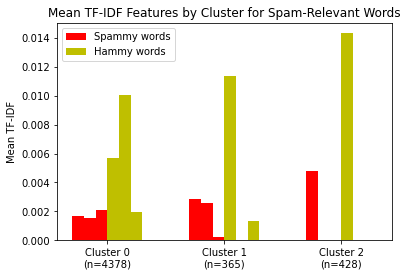

In [5]:
# storing the indices for spammy words
spammy_words = ['click', 'www', 'offer']
spammy_indices = [vocab.index(word) for word in spammy_words]

# storing the indices for hammy words
hammy_words = ['meeting', 'attached', 'review']
hammy_indices = [vocab.index(word) for word in hammy_words]

# for each of the three clusters, plotting the average TF_IDF for each of the six words
plot_spam_words_by_cluster(X, gmm_cluster_assignments, 3, spammy_indices, hammy_indices)

### Part E: Interpret results [10 points]

From the plot generated in part (d), do any of the clusters correspond to spam emails, based on the frequency of spammy and hammy words? Do any of the clusters appear to correspond to typical business emails (ham)? 

Re-run your analysis with a different choice for the number of clusters in your GMM (e.g., `n_clusters=5` or `n_clusters=2`). How does changing the number of clusters affect your results? Does one choice of `n_clusters` appear better than another for locating clusters of spam emails?

The clusters do not appear to have a clear distinction when characterized based on the mean TF-IDF. This is possibly because in most cases, each cluster has a much higher mean TF-IDF value for hammy words than spammy words. However, cluster 1 might "appear" to correspond to spam emails whereas cluster 0 and 2 appear to correspond to ham emails.

Changing the clusters to n = 2 does not add any value to the analysis. However, changing the clusters to n = 5 does improve the results to some extent and helps distinguish spam clusters from non-spam ones, based on the sets of spam and ham words. There are two prominent observations in the graph for n = 5 below: cluster 0 has ham words only, which could help us rule this cluster out as non-spam; cluster 3 has a much higher representation for hammy words, which might make us inclined towards identifying this cluster as non-spam; cluster 2 and 4 appear to be ambiguous.

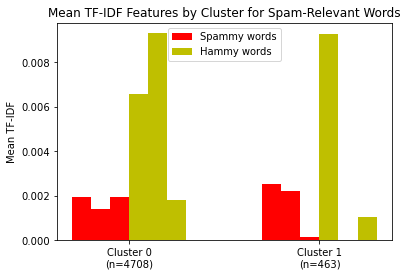

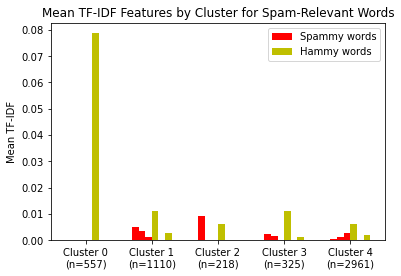

In [6]:
# changing the number of clusters in GMM 
gmm_2 = GaussianMixture(n_components=2, random_state=0)
gmm_2.fit(X) 
gmm_cluster_assignments_2 = gmm_2.predict(X)
plot_spam_words_by_cluster(X, gmm_cluster_assignments_2, 2, spammy_indices, hammy_indices)

# changing the number of clusters in GMM 
gmm_5 = GaussianMixture(n_components=5, random_state=0)
gmm_5.fit(X) 
gmm_cluster_assignments_5 = gmm_5.predict(X)
plot_spam_words_by_cluster(X, gmm_cluster_assignments_5, 5, spammy_indices, hammy_indices)

## Question 2: Latent "Purposes" in Mobile Apps [45 points]


Think of Android applications as "documents", where "words" are the "permissions" that each app requests. Each app has a set of latent "purposes" (topics); a "purpose" may be a specific task (such as taking photographs and uploading them to the internet), and an application may have a mixture of purposes of varying strength.

Can we uncover these purposes from a dataset of Android applications and the permissions they request?

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

### Part A: Load the data [0 points]

The [dataset](http://www.mariofrank.net/andrApps/) contains ~180,000 applications from the Android app store, including each app's name, description and permissions requested. For more about Android app permissions, see [this report](http://www.pewinternet.org/2015/11/10/an-analysis-of-android-app-permissions/).

   * Download the data and unzip it into the same folder as this notebook.
   * Rename the CSV file to "android.csv".
   * Run the cells below to load the data into the notebook.

This may take up ~2GB of RAM.

In [37]:
df = pd.read_csv("android.csv", sep=",",  thousands=",")

In [38]:
df["Number of ratings"] = df["Number of ratings"].astype(int) # fix data type
df = df.drop_duplicates(subset=["App"]).reset_index(drop=True)

In [39]:
df.head(n=3)

,App,Package,Category,Description,Rating,Number of ratings,Price,Related apps,Dangerous permissions count,Safe permissions count,...,Your personal information : read Browser's history and bookmarks (D),Your personal information : read calendar events (D),Your personal information : read contact data (D),Your personal information : read sensitive log data (D),Your personal information : read user defined dictionary (D),Your personal information : retrieve system internal state (S),Your personal information : set alarm in alarm clock (S),Your personal information : write Browser's history and bookmarks (D),Your personal information : write contact data (D),Your personal information : write to user defined dictionary (S)
0,Google Maps,com.google.android.apps.maps,Travel & Local,"Download the latest release of Google Maps, an...",4.4,1438259,$0.00,"{com.jsdfproductions.ctatrackerpro, com.alk.co...",17.0,8,...,0,0,1,0,0,0,0,0,1,0
1,Snowfall Live Wallpaper,fishnoodle.snowfall_free,Personalization,Snowfall Live Wallpaper: Wintertime on your ho...,4.3,18147,$0.00,"{colfore.wallpaper.snowfree, com.tabsoft.wallp...",0.0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aquarium Live Wallpaper,fishnoodle.aquarium_free,Personalization,A beautiful tropical fish tank live wallpaper!...,4.1,62145,$0.00,"{com.convisual.lwp.fishometerlite, com.accessl...",0.0,0,...,0,0,0,0,0,0,0,0,0,0


### Part B: Convert each app into a "document" [0 points]

The code below does the following:

   * Filter out all the columns except the permission columns.
   * Convert this dataframe into a numpy matrix.

There are thus 180295 apps (documents) and 173 permissions (words).

   - `X` is the "document" or "word-frequency" matrix.
   - `permission_columns` contains the words ordered by their column index in X.
   - `app_names` contains the application names ordered by their row index in X.
   - `app_ratings` contains the *number* of application ratings (not the ratings themselves).

In [40]:
permission_columns = list(df.columns[10:])
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])
df_perms = df[permission_columns]
X = df_perms.values # for each application (row), contains binary columns indicating if a certain permission is required 
# del df # uncomment to free up RAM
# del df_perms # uncomment to free up RAM

### Part C: Downweight "stopwords" [2.5 points]

There are some permissions requested by almost all applications (like "INTERNET"), they are similar to stop-words ("the", "and", etc.) in natural language. We can downweight them by TF-IDF normalization.

   * Use the `TfidfTransformer` class in `scikit-learn` to transform X.

In [41]:
# Note: tf–idf value increases proportionally to the number of times a word appears in the document 
# and is offset by the number of documents in the corpus that contain the word, 
# which helps to adjust for the fact that some words appear more frequently in general
from sklearn.feature_extraction.text import TfidfTransformer

# since permissions which are required by all applications add minimal classification value (similar to stop words),
# we downweight them using TF-IDF instead of simply using TF  
X = TfidfTransformer().fit_transform(X)

### Part D: Discover 10 "topics" [2.5 points]

   * Use the `LatentDirichletAllocation` class in `scikit-learn` to fit 10 topics to the data.
   * Use 10 max iterations, set `n_jobs=-1` to use all cores on your machine (if it helps).
   * Feel free to understand and play around with other parameters.
   * This may take around 3 minutes to run.

In [42]:
%%time
from sklearn.decomposition import LatentDirichletAllocation

num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, n_jobs = -1, max_iter = 10, random_state=0)

# using LDA on TF-IDF array X (rows are documents/applications and columns are words/permissions)
lda.fit(X)

Wall time: 4min 29s


LatentDirichletAllocation(n_jobs=-1, random_state=0)

In [43]:
# checking the shape of the output from LDA (10 topics, 173 permissions)
lda.components_.shape

(10, 173)

In [44]:
# to convert TF-IDF array to a probalitiy distribution of permissions for each topic (normalization)
topic_permissions_distributions = np.array([row / row.sum() for row in lda.components_])

# to verify that for each topic identified by LDA, the sum of probs across all permissions is equal to 1
topic_permissions_distributions.sum(axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Now each app can be viewed as a distribution over these 10 topics, and each topic is a distribution over all the permissions in the data.

### Part E: List the top 10 "words" in each topic [15 points]

Do any of the topics correspond to meaningful app "purposes"? List the ones you find meaningful below:

   * Topic #i: "your interpretation"

In [45]:
num_topics = len(topic_permissions_distributions)
num_top_permissions = 10
print('Displaying the top %d permissions per topic and their probabilities within the topic...' % num_top_permissions)
print('\n')
features = permission_columns 

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, '] \n', sep='')
    # sorting the probabilities of permissions for each row i.e. topic, and saving the sorted indices
    sort_indices = np.argsort(-topic_permissions_distributions[topic_idx])
    for rank in range(num_top_permissions): # top 10 words i.e. permissions only
        # saving the index from the top 10 indices in sort_indices (one at a time) 
        perm_idx = sort_indices[rank]
        # using the saved index to retreive the permission name from df_perms & corresponding cell in topic_permissions_dist
        print(features[perm_idx], ':', topic_permissions_distributions[topic_idx, perm_idx])
    print()

Displaying the top 10 permissions per topic and their probabilities within the topic...


[Topic 0] 

Your location : coarse (network-based) location (D) : 0.25263653565583427
Your location : fine (GPS) location (D) : 0.24252720873391073
Network communication : full Internet access (D) : 0.15199326092068594
Network communication : view network state (S) : 0.10141803527778044
Phone calls : read phone state and identity (D) : 0.08185838560381938
Storage : modify/delete USB storage contents modify/delete SD card contents (D) : 0.06379643094513857
Services that cost you money : directly call phone numbers (D) : 0.051092697118316786
Network communication : view Wi-Fi state (S) : 0.026962007867490183
Your personal information : read sensitive log data (D) : 0.02158493529798257
Hardware controls : test hardware (S) : 0.0021507584583803823

[Topic 1] 

Hardware controls : control vibrator (S) : 0.43315286583604024
Network communication : full Internet access (D) : 0.14102352919735206
Network c

Topic 5 could be about storage since it assigns a high probability to modifying/deleting USB storage contents. It also includes permissions to mount and unmount filesystems.

Topic 6 involves permissions for taking pictures & videos, and recording audio, which might be indicative that this topic is related to social media. If we look at the topic distribution for each application, we might find apps like Google Photos having a high probability for this topic.

Topic 7 is possibly about wifi-services, since it has viewing and changing wifi state as one of its top 10 permissions. It also include creating bluetooth connections, possibly for hotspot usage.

### Part F: For each topic, list the top 3 apps with at least 100000 ratings having the highest probability assigned to that topic [15 points]

   - This further helps us understand what the topics actually mean.
   - However, the data is noisy and this exercise may result in listing a bunch of obscure apps.
   - Hence, filtering out all apps with less than 100000 ratings may help.

In [47]:
# Note: transformed X from part C is an TF-IDF array of size (180295, 173) i.e. (applications, permissions)
# Fitting LDA on X in part D allowed us to get a get an output of (10, 173) i.e. (topics, permissions)

# Now we transform X such that in the array app_topic_matrix we get:
# for each document i.e. application (row), the proportion of the application covering each topic (column) -> (180295, 10)
app_topic_matrix = lda.transform(X)

# checking if the topic probabilities for each application, sums to 1
app_topic_matrix.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [50]:
# setting the parameters from the dataset
num_top_apps = 3
app_names = list(df["App"])
app_ratings = np.array(df["Number of ratings"])

# filtering out appplications with ratings less than 10000
filtered_boolean = app_ratings >= 100000
# empty list of indices for applications meeting the above condition
filtered_indices = []
for idx, boolean in enumerate(filtered_boolean):
    if boolean == True:
        filtered_indices.append(idx)

# using the filtered indices to restrict rows in the 2D-array app_topic matrix 
filtered_app_topic_matrix = app_topic_matrix[filtered_indices, :]
filtered_app_names = [app_names[i] for i in filtered_indices]

# printing out apps with the top 3 probabilities for each topic (column) in app_topic_matrix
print('Displaying the top %d applications per topic and their probabilities for the topic...' % num_top_apps)
print('\n')

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, '] \n', sep='')
    # since each column is now a topic, we are sorting the probabilities in each column
    sort_indices = np.argsort(-filtered_app_topic_matrix[:, topic_idx])
    for rank in range(num_top_apps): # apps with the top 3 probabilities for each topic
        # saving the index from the top 3 indices in sort_indices (one at a time) 
        app_idx = sort_indices[rank]
        # using the saved index to retreive the permission name from df_perms & corresponding (app, topic) probability
        print(filtered_app_names[app_idx], ':', filtered_app_topic_matrix[app_idx, topic_idx])
    print()

Displaying the top 3 applications per topic and their probabilities for the topic...


[Topic 0] 

Dictionary.com : 0.7169209884462354
Air Control Lite : 0.7169209884462354
Paper Toss : 0.6935381403208715

[Topic 1] 

Live Holdem Poker Pro : 0.7166983183679115
Vaulty Free Hides Pictures : 0.7166983183679115
Bubble Blast 2 : 0.6932401124059416

[Topic 2] 

Angry Birds Seasons : 0.6247330077338598
Yoo Ninja! Free : 0.6247330077338598
Adobe Reader : 0.549969102236762

[Topic 3] 

Lookout Security & Antivirus : 0.8569163447537493
Antivirus Free : 0.8544503907474101
WhatsApp Messenger : 0.8455299046384344

[Topic 4] 

Real BlackJack : 0.7163520872799772
Alchemy : 0.7154622330070897
Tank Hero : 0.7153334203786537

[Topic 5] 

World Newspapers : 0.6962019779666523
Paradise Island : 0.6962019779666523
My Country : 0.6962019779666523

[Topic 6] 

Brightest Flashlight Free™ : 0.7624657178487542
Brightest Flashlight Free??? : 0.7624657178487542
Tiny Flashlight + LED : 0.749671949061801

[Topic 7]

### Part G: Visualize the document-topic proportion matrix in 2-D using t-SNE [10 points]

Does our reduced dimensional space contain any structure? Visualize the documents (in the topic-space) using t-SNE.

   * Use `TSNE` from `scikit-learn`.
   * Set the angle to 0.99 and init to 'PCA'. Pick any learning rate that gives you a visually pleasing result.
   * You may `fit` TSNE to a sample of the data (>1000 documents) instead of the full data.
   * Remember to call `fit_transform` to obtain your 2-D data.
   * Plot the t-SNE dimensions as a scatterplot.
   * Color each point based on its most probable topic. Make sure you include a legend (10 colors).
   
Clusters in the t-SNE plot indicate groups of apps that have similar topics.

In [58]:
from sklearn.manifold import TSNE

# setting the parameters for tsne model (for each app, reducing the topics/dimensions from 10 to 2 for visualization)
tsne = TSNE(n_components=2, random_state=0, verbose=1, angle=0.99, init='pca', perplexity=40, learning_rate=500)

# fitting TSNE on app_topic_matrix and transforming the output
topic_tsne2d = tsne.fit_transform(app_topic_matrix[:1000, :])
# for each row, returns index of the maximum value across all columns i.e. the topic with the highest prob for that app 
most_prob_indices = np.argmax(app_topic_matrix[:1000, :], axis=1)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.010s...
[t-SNE] Computed neighbors for 1000 samples in 0.162s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.221020
[t-SNE] KL divergence after 1000 iterations: -0.173813


Text(0.5, 1.0, 'Clustering in the tSNE 2D-Space: Applications w/ Similar Topics \n Learning Rate = 500, Perplexity = 40')

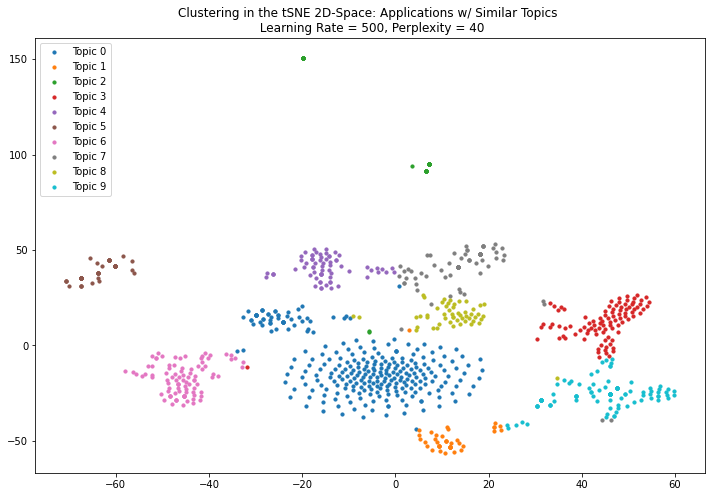

In [66]:
# setting figure size
plt.rcParams["figure.figsize"] = (12, 8)

for topic in range(num_topics):
    # for each topic, restricting rows in tSNE space to only those apps that have the highest probability for this topic
    # plotting all x, y points in tSNE space 
    plt.scatter(topic_tsne2d[most_prob_indices == topic, 0], topic_tsne2d[most_prob_indices == topic, 1], 
                s = 10, label = "Topic " + str(topic))
plt.legend(loc='upper left')
plt.title('Clustering in the tSNE 2D-Space: Applications w/ Similar Topics \n Learning Rate = 500, Perplexity = 40')

It can be seen above that reducing features to a 2D t-SNE space and then coloring/assigning each application to the topic which has the highest probability, give us a clear distinction between clusters. Similar colored points are mostly grouped close together, and the perplexity seems well balanced as well since there are not too many groups.

## Question 3: Questionnaire [5 points]

Please answer this survey after you have done this homework: https://forms.gle/XS94EpxXeQMKdy1e9